In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance 
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import partial_dependence, plot_partial_dependence

In [2]:
df_customers= pd.read_csv('C:/Users/gram/Desktop/기계학습기초/기말프로젝트_데이터공유불가-20211208T111119Z-001/기말프로젝트_데이터공유불가/Customers.csv')
df_transactions= pd.read_csv('C:/Users/gram/Desktop/기계학습기초/기말프로젝트_데이터공유불가-20211208T111119Z-001/기말프로젝트_데이터공유불가/Transactions.csv')

In [3]:
df_customers.info()
df_customers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49995 entries, 0 to 49994
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   custid     49995 non-null  int64 
 1   sex        49995 non-null  int64 
 2   birth      49995 non-null  object
 3   birth_flg  49995 non-null  int64 
 4   mrg_flg    49995 non-null  int64 
 5   h_type1    49995 non-null  object
 6   h_type2    49995 non-null  int64 
 7   hobby      49995 non-null  int64 
 8   job_stype  49995 non-null  int64 
 9   cus_stype  49995 non-null  int64 
 10  m_time1    49995 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 4.2+ MB


,custid,sex,birth,birth_flg,mrg_flg,h_type1,h_type2,hobby,job_stype,cus_stype,m_time1
0,1,0,$null$,-1,1,A,1,17,4110,7,37
1,2,0,$null$,-1,1,N,1,17,7060,7,31
2,3,0,$null$,-1,1,A,2,17,4070,6,22
3,4,2,1982-09-07 00:00:00,1,2,N,4,11,4520,9,35
4,5,2,1982-08-17 00:00:00,1,2,Z,3,17,4520,9,-1
...,...,...,...,...,...,...,...,...,...,...,...
49990,49996,0,1911-08-13 00:00:00,2,1,N,1,17,4500,1,30
49991,49997,1,1911-01-10 00:00:00,1,1,V,1,17,7060,3,30
49992,49998,1,1970-09-28 00:00:00,1,1,Z,3,17,3070,6,34
49993,49999,0,1943-02-28 00:00:00,1,1,A,4,2,1490,10,-1


In [4]:
df_transactions.info()
df_transactions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1726430 entries, 0 to 1726429
Data columns (total 11 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   sales_date  object
 1   custid      int64 
 2   goodcd      int64 
 3   brd_nm      object
 4   team_nm     object
 5   part_nm     object
 6   pc_nm       object
 7   corner_nm   object
 8   tot_amt     int64 
 9   dis_amt     int64 
 10  net_amt     int64 
dtypes: int64(5), object(6)
memory usage: 144.9+ MB


,sales_date,custid,goodcd,brd_nm,team_nm,part_nm,pc_nm,corner_nm,tot_amt,dis_amt,net_amt
0,2000-05-01 00:00:00,7595,2700000000000,식품,식품팀,공산품,일반식품,주류,28000,0,28000
1,2000-05-01 00:00:00,36860,2700000000000,식품,식품팀,공산품파트,일반식품,차류,59700,0,59700
2,2000-05-01 00:00:00,48385,4125270007985,슈프리미아,잡화가용팀,잡화파트,장신구,화장잡화,17000,0,17000
3,2000-05-01 00:00:00,29611,4508720043900,삼운/브로니,잡화가용팀,가정용품,식기,욕실용품,14000,700,13300
4,2000-05-01 00:00:00,16457,4120441805900,베네통토탈,의류패션팀,영플라자,소품,피혁토탈(B2),5800,290,5510
...,...,...,...,...,...,...,...,...,...,...,...
1726425,2001-04-29 00:00:00,22903,4409270126000,스포트리플레이,의류패션팀,영플라자,진캐주얼,스포츠캐주얼,27300,0,27300
1726426,2001-04-29 00:00:00,32832,6240990026001,쌈지스포츠,잡화가용팀,"아동,스포츠",(주)현스포츠아쌤,미확인코너,144000,7200,136800
1726427,2001-04-29 00:00:00,18628,2700000000000,식품,식품팀,공산품,일반식품,음료,8340,0,8340
1726428,2001-04-29 00:00:00,38077,2700000000000,식품,식품팀,생식품,미확인pc,용기보증,23170,0,23170


In [5]:
def check_null(df):
    perc_na = (df.isnull().sum() / len(df))*100
    ratio_na = perc_na.sort_values(ascending=False)
    return [(idx, val) for idx, val in zip(ratio_na.index, 
                                           ratio_na.values)]

In [6]:
check_null(df_transactions)

[('net_amt', 0.0),
 ('dis_amt', 0.0),
 ('tot_amt', 0.0),
 ('corner_nm', 0.0),
 ('pc_nm', 0.0),
 ('part_nm', 0.0),
 ('team_nm', 0.0),
 ('brd_nm', 0.0),
 ('goodcd', 0.0),
 ('custid', 0.0),
 ('sales_date', 0.0)]

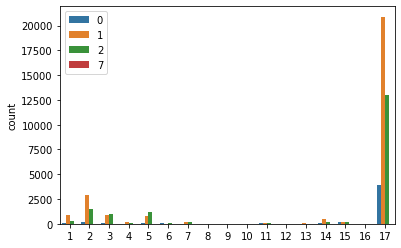

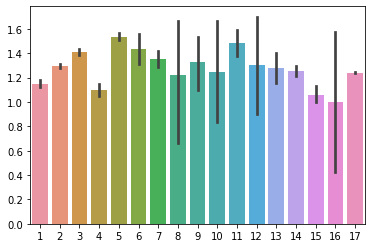

In [7]:
X = df_customers['hobby'].values
Y = df_customers['mrg_flg'].values

sns.countplot(x=X, hue =Y,data=df_customers)
plt.show()

sns.barplot(x=X, y=Y,data=df_customers)
plt.show()

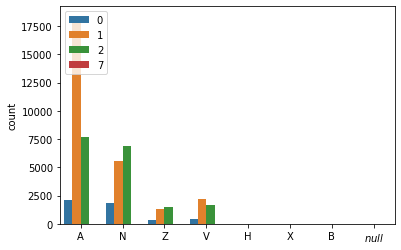

In [8]:
X = df_customers['h_type1'].values
Y = df_customers['mrg_flg'].values

sns.countplot(x=X, hue =Y,data=df_customers)
plt.show()

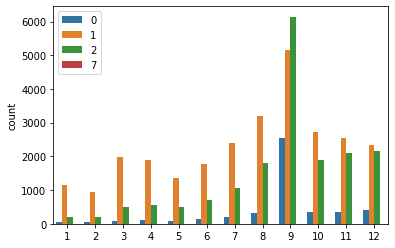

In [9]:
X = df_customers['cus_stype'].values
Y = df_customers['mrg_flg'].values

sns.countplot(x=X, hue =Y,data=df_customers)
plt.show()

In [10]:
df_transactions_add = pd.merge(df_transactions, df_customers[['custid', 'mrg_flg']], left_on='custid', right_on='custid', how='outer')

In [11]:
df_transactions_add['sales_date'] = pd.to_datetime(df_transactions_add['sales_date'])
df_transactions_add

,sales_date,custid,goodcd,brd_nm,team_nm,part_nm,pc_nm,corner_nm,tot_amt,dis_amt,net_amt,mrg_flg
0,2000-05-01,7595,2700000000000,식품,식품팀,공산품,일반식품,주류,28000,0,28000,2
1,2000-05-05,7595,4536970039076,산리전자,잡화가용팀,가정용품,가전,소형취사가전,70000,0,70000,2
2,2000-05-07,7595,4400590025000,아놀드파마,잡화가용팀,스포츠캐주얼,골프,골프웨어,152000,7600,144400,2
3,2000-05-07,7595,4418210027000,나이키의류,잡화가용팀,스포츠캐주얼,스포츠,스포츠웨어,34000,1700,32300,2
4,2000-05-07,7595,2700000000000,식품,식품팀,생식품,미확인pc,용기보증,19444,0,19444,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1726425,2001-04-29,3534,2116050008000,에스티로더,잡화가용팀,패션잡화,화장품,수입종합화장품,225000,11250,213750,2
1726426,2001-04-29,18203,4109161008000,겔랑,잡화가용팀,패션잡화,화장품,수입종합화장품,83000,4150,78850,2
1726427,2001-04-29,18203,4104840008000,샤넬,잡화가용팀,패션잡화,화장품,수입종합화장품,52000,2600,49400,2
1726428,2001-04-29,4888,4104840008000,샤넬,잡화가용팀,잡화,화장품,수입종합화장품,52000,2600,49400,1


In [12]:
category_column = ['brd_nm', 'team_nm', 'part_nm', 'pc_nm', 'corner_nm']
for c in category_column :
    encoder = LabelEncoder()
    encoder.fit(df_transactions_add[c])
    df_transactions_add[c] = encoder.transform(df_transactions_add[c])

In [13]:
df_transactions_add

,sales_date,custid,goodcd,brd_nm,team_nm,part_nm,pc_nm,corner_nm,tot_amt,dis_amt,net_amt,mrg_flg
0,2000-05-01,7595,2700000000000,994,1,3,51,227,28000,0,28000,2
1,2000-05-05,7595,4536970039076,837,4,0,2,116,70000,0,70000,2
2,2000-05-07,7595,4400590025000,1045,4,13,4,30,152000,7600,144400,2
3,2000-05-07,7595,4418210027000,249,4,13,35,149,34000,1700,32300,2
4,2000-05-07,7595,2700000000000,994,1,11,23,182,19444,0,19444,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1726425,2001-04-29,3534,2116050008000,1176,4,30,77,136,225000,11250,213750,2
1726426,2001-04-29,18203,4109161008000,139,4,30,77,136,83000,4150,78850,2
1726427,2001-04-29,18203,4104840008000,856,4,30,77,136,52000,2600,49400,2
1726428,2001-04-29,4888,4104840008000,856,4,27,77,136,52000,2600,49400,1


In [14]:
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (12, 10)

In [15]:
df_transactions_add_report=sweetviz.analyze(df_transactions_add)
df_transactions_add_report.show_html()

                                             |                                             | [  0%]   00:00 ->…

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [16]:
train_data = df_transactions_add

y_column = 'mrg_flg'
x_column = list(train_data.columns)
x_column.remove(y_column)

#날짜 요소는 나중에 Trend 분석으로 활용
x_column.remove('sales_date')

#고객번호 별 분류 성능에 많은 영향을 미치는 므로 제거
x_column.remove('custid')

In [17]:
train_x, test_x, train_y, test_y = train_test_split(train_data[x_column], train_data[y_column], 
                                                        test_size=0.2, shuffle=True, random_state=1)

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, 
                                                        test_size=0.1, shuffle=True, random_state=1)

In [18]:
model=XGBClassifier(booster='gbtree', 
                    max_depth=5, 
                    n_estimators=50, 
                    objective='multi:softprob', 
                    eval_metric='merror'
                    )

In [19]:
model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=30)

[0]	validation_0-merror:0.336314
Will train until validation_0-merror hasn't improved in 30 rounds.
[1]	validation_0-merror:0.337023
[2]	validation_0-merror:0.33664
[3]	validation_0-merror:0.336625
[4]	validation_0-merror:0.33643
[5]	validation_0-merror:0.336618
[6]	validation_0-merror:0.336502
[7]	validation_0-merror:0.336683
[8]	validation_0-merror:0.336661
[9]	validation_0-merror:0.336582
[10]	validation_0-merror:0.336567
[11]	validation_0-merror:0.336538
[12]	validation_0-merror:0.336546
[13]	validation_0-merror:0.336502
[14]	validation_0-merror:0.336271
[15]	validation_0-merror:0.336249
[16]	validation_0-merror:0.33614
[17]	validation_0-merror:0.336032
[18]	validation_0-merror:0.335988
[19]	validation_0-merror:0.335662
[20]	validation_0-merror:0.33551
[21]	validation_0-merror:0.335481
[22]	validation_0-merror:0.335402
[23]	validation_0-merror:0.335351
[24]	validation_0-merror:0.3353
[25]	validation_0-merror:0.335315
[26]	validation_0-merror:0.335286
[27]	validation_0-merror:0.3350

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

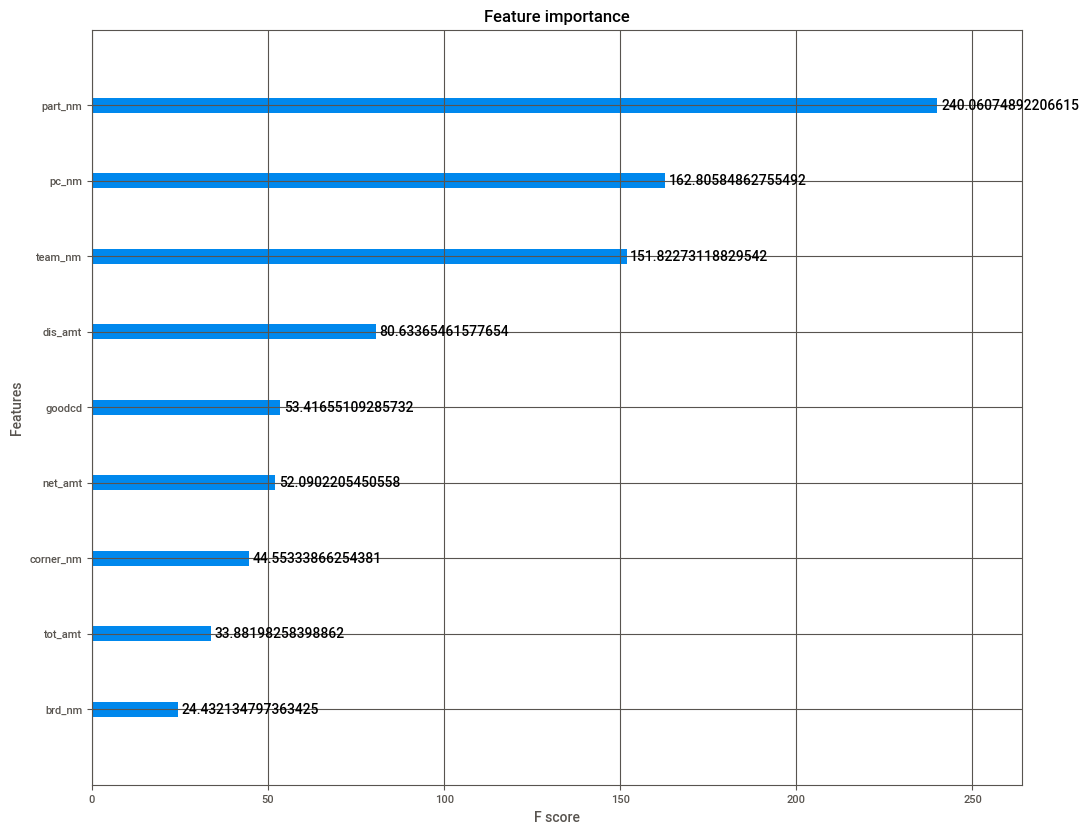

In [20]:
plot_importance(model, importance_type = 'gain')
plt.show()

In [21]:
y_pred = model.predict(test_x)

In [22]:
acc_score = accuracy_score(test_y, y_pred)
result = classification_report(test_y, y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
print(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     23536
           1       0.67      0.99      0.80    227794
           2       0.53      0.04      0.08     93956

    accuracy                           0.66    345286
   macro avg       0.40      0.34      0.29    345286
weighted avg       0.58      0.66      0.55    345286



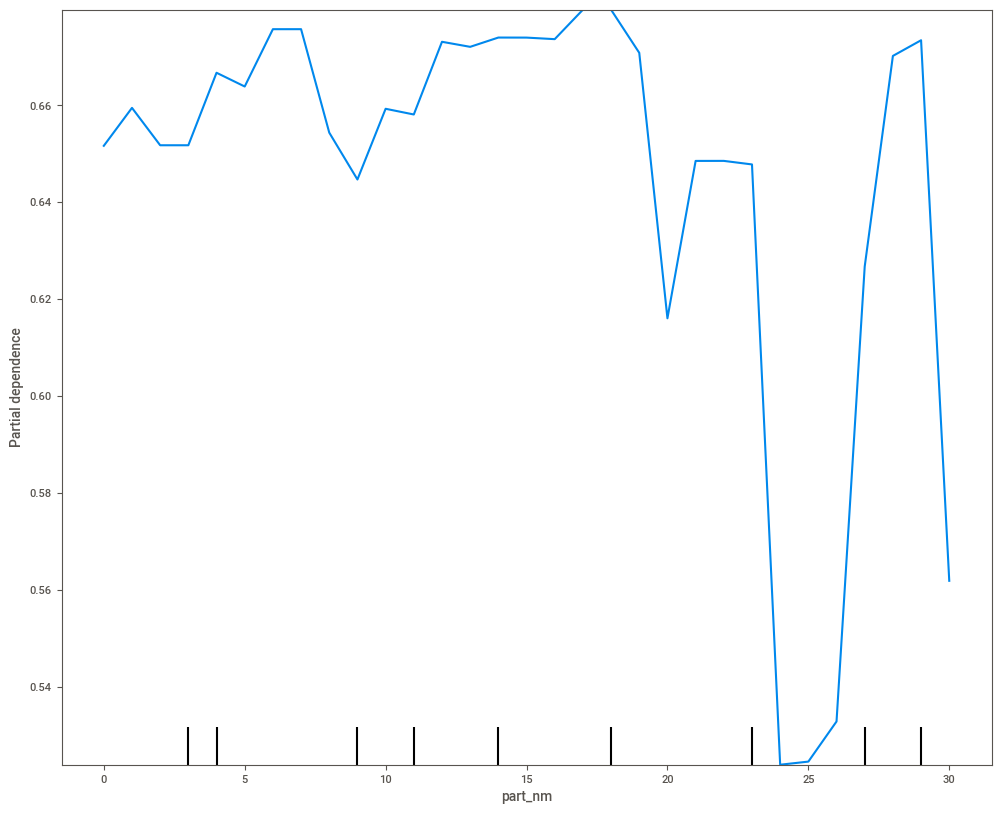

In [24]:
plot_partial_dependence(model, train_x, ['part_nm'], target=1)
plt.show()

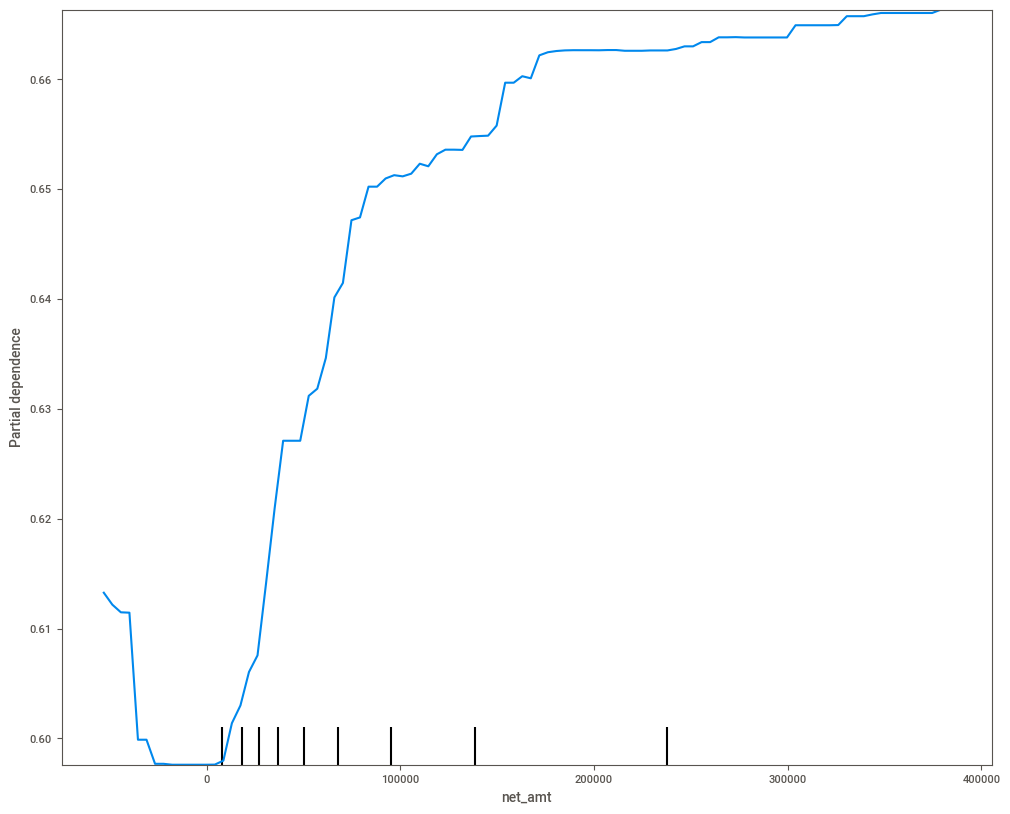

In [25]:
plot_partial_dependence(model, train_x, ['net_amt'], target=1)
plt.show()

In [26]:
from tqdm import tqdm
 
customer_id = list(df_transactions_add['custid'].unique()) ## 고객아이디
 
## 먼저 각 고객별로 구매금액이 얼마인지 알아보자.
monetary_df = pd.DataFrame() ## 구매금액 데이터 초기화
monetary_df['custid'] = customer_id ## 고객아이디 삽입
 
monetary_data = [] ## 구매금액을 담을 리스트
for ci in tqdm(customer_id,position=0,desc='Calculating amount of individual customer'):
    temp = df_transactions_add.query('custid==@ci') ## 해당 아이디의 고객데이터 추출
    amount = sum(temp['tot_amt']) ## 해당 고객 구매금액
    monetary_data.append(amount)
    
monetary_df['Monetary'] = monetary_data ## 구매금액 데이터 삽입

Calculating amount of individual customer: 100%|█████████████████████████████████| 49995/49995 [15:39<00:00, 53.20it/s]


In [27]:
## 각 고객별 최근방문일을 알아보자.
temp_recency_df = df_transactions_add[['custid','sales_date']].drop_duplicates() ## 고객 아이디와 구매날짜만 추출한뒤 중복 제거
recency_df = temp_recency_df.groupby('custid')['sales_date'].max().reset_index() ## 아이디로 그룹화 한다음 최근방문일을 구해야 하므로 구매날짜에 max를 적용한다.
recency_df = recency_df.rename(columns={'sales_date':'Recency'})
 
# ## 각 고객별 방문횟수를 알아보자.
temp_frequency_df = df_transactions_add[['custid','goodcd']].drop_duplicates() ## 고객 아이디와 구매번호만 추출한뒤 중복 제거
frequency_df = temp_frequency_df.groupby('custid')['goodcd'].count().reset_index() ## 아이디로 그룹화 한다음 방문횟수를 구해야 한다. 여기서는 방문횟수를 구매번호 개수로 생각했으므로 구매번호에 count를 적용한다.
frequency_df = frequency_df.rename(columns={'goodcd':'Frequency'})
 
# ## 데이터를 고객아이디를 기준으로 합쳐야한다.
rfm_df = pd.merge(recency_df,frequency_df,how='left',on='custid')
rfm_df = pd.merge(rfm_df,monetary_df,how='left',on='custid')

current_day = pd.to_datetime('20000101') ## 기준 날짜를 2000년 1월 1일 0시 0분으로 잡았다.
time_diff = rfm_df['Recency']-current_day ## 최근방문일과 기준 날짜의 시간 차이
time_in_seconds = [x.total_seconds() for x in time_diff] ## 시간 차이를 초단위로 계산
rfm_df['Recency'] = time_in_seconds ## 변환된 데이터를 다시 삽입한다.

rfm_merge = pd.merge(rfm_df, df_customers[['custid', 'mrg_flg']], left_on='custid', right_on='custid', how='outer')

In [28]:
pd.options.display.float_format = '{:.5f}'.format
rfm_merge.describe()

,custid,Recency,Frequency,Monetary,mrg_flg
count,49995.00000,49995.00000,49995.00000,49995.00000,49995.00000
mean,25002.44504,37686809.00090,19.06027,3407255.11601,1.26189
std,14433.27809,5903495.37767,17.17040,5105558.79844,0.61846
min,1.00000,10454400.00000,1.00000,-11390811.00000,0.00000
25%,12504.50000,36892800.00000,7.00000,713224.00000,1.00000
50%,25003.00000,40176000.00000,14.00000,1791300.00000,1.00000
75%,37501.50000,41212800.00000,26.00000,4037737.00000,2.00000
max,50000.00000,41817600.00000,241.00000,126220097.00000,7.00000


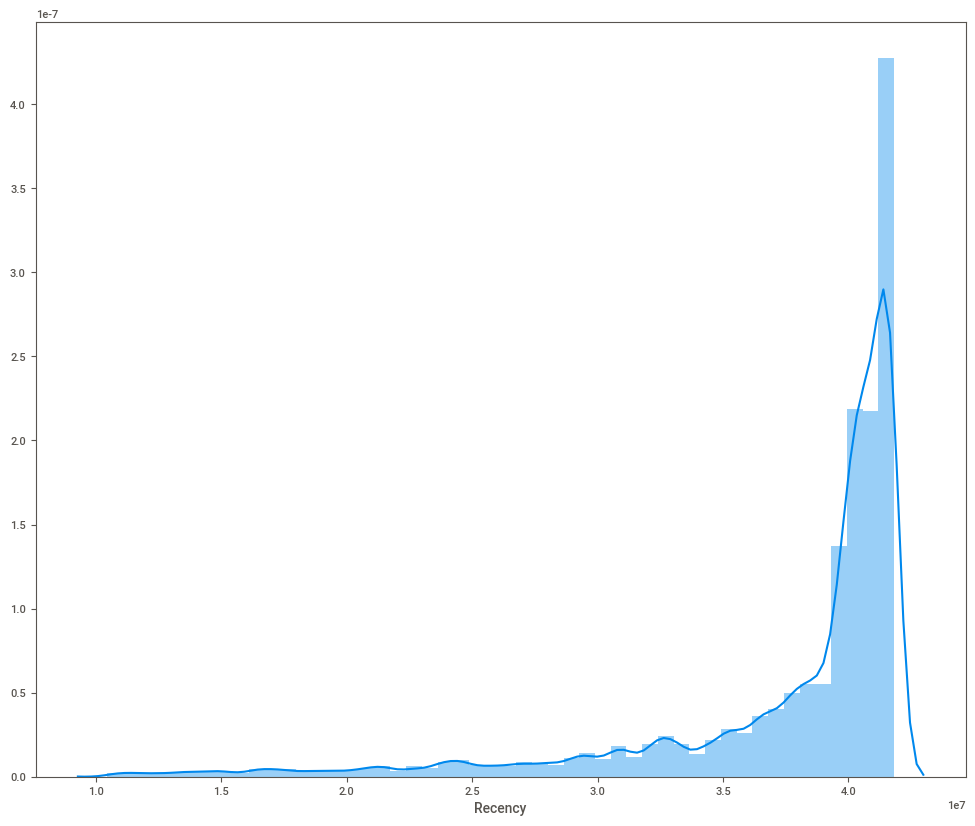

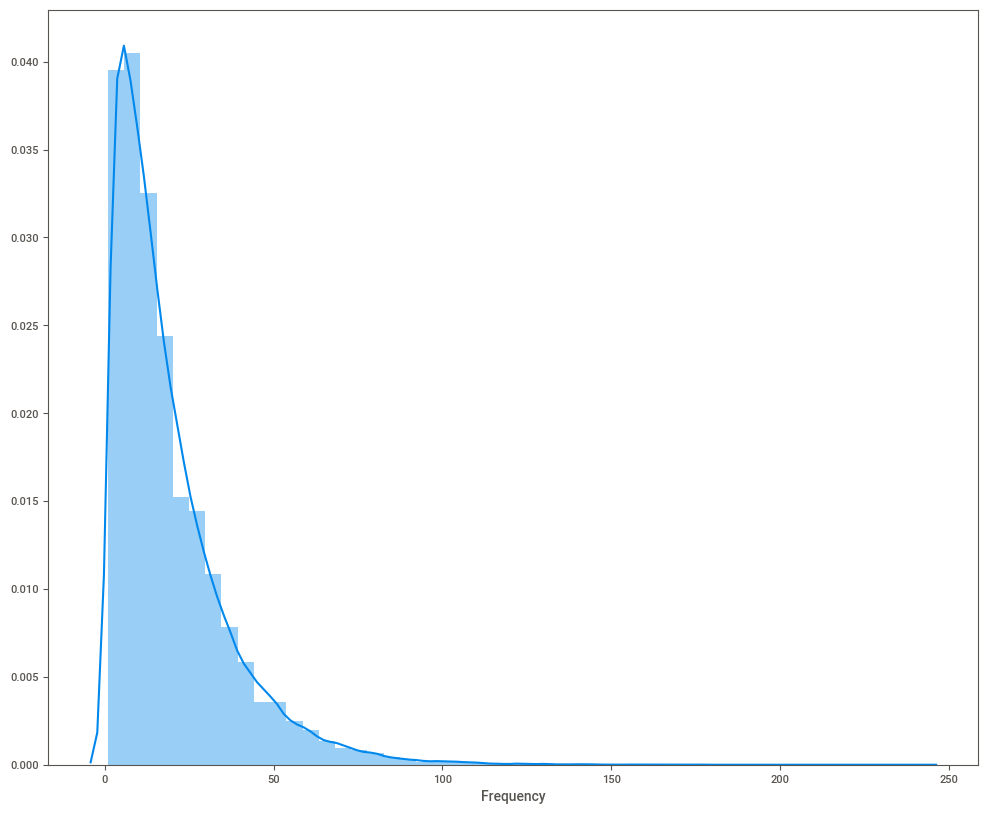

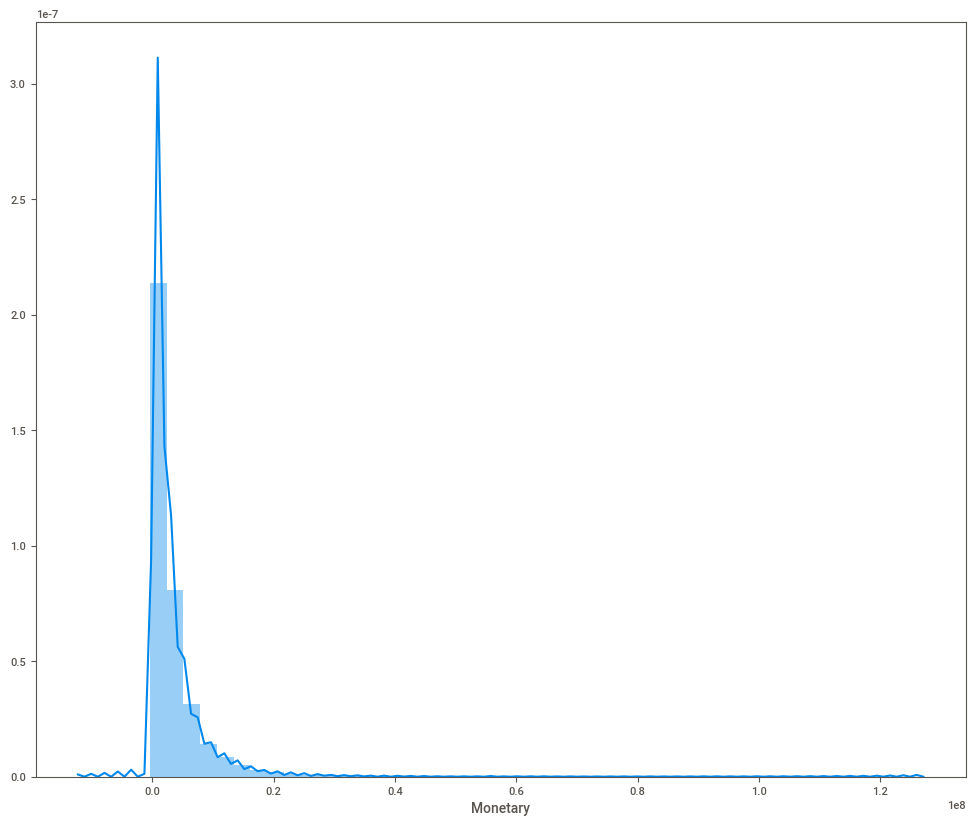

In [29]:
sns.distplot(rfm_merge['Recency'])
plt.show()
sns.distplot(rfm_merge['Frequency'])
plt.show()
sns.distplot(rfm_merge['Monetary'])
plt.show()

In [30]:
# set the bins [<min, x, x, max]
r_bins = [10454400, 36892800, 41212800, 41817600]
f_bins = [1, 7, 26, 241]
m_bins = [-11390811, 713224, 4037737, 126220097]
rfm_merge['r_score'] = pd.cut(rfm_merge['Recency'], r_bins, labels = [3, 2, 1])
rfm_merge['f_score'] = pd.cut(rfm_merge['Frequency'], f_bins, labels = [1, 2, 3])
rfm_merge['m_score'] = pd.cut(rfm_merge['Monetary'], m_bins, labels = [1, 2, 3])

In [31]:
rfm_merge

,custid,Recency,Frequency,Monetary,mrg_flg,r_score,f_score,m_score
0,1,41817600.00000,29,3800481,1,1,3,2
1,2,40262400.00000,17,2132329,1,2,2,2
2,3,41644800.00000,37,6491639,1,1,3,3
3,4,40521600.00000,6,409400,2,2,1,1
4,5,41472000.00000,4,173000,2,1,1,1
...,...,...,...,...,...,...,...,...
49990,49996,41817600.00000,39,99190685,1,1,3,3
49991,49997,41644800.00000,22,8425120,1,1,2,3
49992,49998,40953600.00000,22,1825746,1,2,2,2
49993,49999,41558400.00000,12,3092703,1,1,2,2


In [32]:
x = rfm_merge[['Recency', 'Frequency', 'Monetary']]
y = rfm_merge['mrg_flg']
rfm_model=XGBClassifier(booster='gbtree', 
                    max_depth=5, 
                    n_estimators=50, 
                    objective='multi:softprob', 
                    eval_metric='merror'
                    )
rfm_model.fit(x, y)
weights = rfm_model.feature_importances_

In [33]:
r_score = rfm_merge['r_score'].astype('float')
f_score = rfm_merge['f_score'].astype('float')
m_score = rfm_merge['m_score'].astype('float')

rfm_merge['rfm_score'] = r_score*weights[0] + f_score*weights[1] + m_score*weights[2]

In [34]:
rfm_merge

,custid,Recency,Frequency,Monetary,mrg_flg,r_score,f_score,m_score,rfm_score
0,1,41817600.00000,29,3800481,1,1,3,2,2.01853
1,2,40262400.00000,17,2132329,1,2,2,2,2.00000
2,3,41644800.00000,37,6491639,1,1,3,3,2.63490
3,4,40521600.00000,6,409400,2,2,1,1,1.18255
4,5,41472000.00000,4,173000,2,1,1,1,1.00000
...,...,...,...,...,...,...,...,...,...
49990,49996,41817600.00000,39,99190685,1,1,3,3,2.63490
49991,49997,41644800.00000,22,8425120,1,1,2,3,2.43382
49992,49998,40953600.00000,22,1825746,1,2,2,2,2.00000
49993,49999,41558400.00000,12,3092703,1,1,2,2,1.81745


In [35]:
# clustering 분석

from sklearn.cluster import KMeans 

# k-means clustering 실행
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_merge[['Recency', 'Frequency', 'Monetary']])
rfm_merge["k_cluster"] = kmeans.labels_

In [37]:
rfm_merge

,custid,Recency,Frequency,Monetary,mrg_flg,r_score,f_score,m_score,rfm_score,k_cluster
0,1,41817600.00000,29,3800481,1,1,3,2,2.01853,0
1,2,40262400.00000,17,2132329,1,2,2,2,2.00000,0
2,3,41644800.00000,37,6491639,1,1,3,3,2.63490,0
3,4,40521600.00000,6,409400,2,2,1,1,1.18255,0
4,5,41472000.00000,4,173000,2,1,1,1,1.00000,0
...,...,...,...,...,...,...,...,...,...,...
49990,49996,41817600.00000,39,99190685,1,1,3,3,2.63490,2
49991,49997,41644800.00000,22,8425120,1,1,2,3,2.43382,0
49992,49998,40953600.00000,22,1825746,1,2,2,2,2.00000,0
49993,49999,41558400.00000,12,3092703,1,1,2,2,1.81745,0
